# randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples
Andrew E. Davidson  
aedaivds@ucsc.edu
1/31/24

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

ref : [testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb](testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb)

**Logistic Regression baseline results** 
- pipelineStageName = "best10CuratedDegree1_ce467ff"
- 43 healthy donor plasma sample, 35 lung cancer plasma samples
- specificity = 0.86
- sensitivity = 0.6

TODO AEDWIP

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

# import joblib
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import pprint as pp
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    

meaningOfLife = 42

/data/tmp/ipykernel_1093883/1484917113.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


outDir:
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavid

In [3]:
# import local 
from analysis.utilities import findFile
from intraExtraRNA.elifeUtilities import loadElifeLungTrainingData

In [4]:
%%time
HUGO_lungGenes, elifeLungGenes, countDF, metaDF, XNP, yNP = loadElifeLungTrainingData()

2024-02-07 13:10:21,070 WARNING intraExtraRNA.elifeUtilities loadElifeLungTrainingData() line:107] [len(elifeLungGenes) : 30]
2024-02-07 13:10:21,071 WARNING intraExtraRNA.elifeUtilities loadElifeLungTrainingData() line:108] [missingElifeGenes
 : ['ENSG00000274031.1']]


refSeq2ENSGDF.loc[selectRows, :] :
              HUGO               ENSG bioType
97713   AC111149.2  ENSG00000253339.2  lncRNA
172016  AC092140.2  ENSG00000274031.1  lncRNA
203145      PCAT19  ENSG00000267107.8  lncRNA
CPU times: user 24.9 s, sys: 3.08 s, total: 27.9 s
Wall time: 27.9 s


In [5]:
# https://stackoverflow.com/a/64540588/4586180
# The specifity is basically the True Negative Rate which is the same as the True Positive Rate (Recall)
# but for the negative class
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
specificity = make_scorer(recall_score, pos_label=0)

scoringMetricsDict = {
    'accuracy' : 'accuracy', # TP
    'sensitivity' : 'recall',
    'specificity' : specificity,
    #'f1' : 'f1'
}    

# Train Random Forest Classifier

In [6]:
%%time

def testDefault():
    model = RandomForestClassifier()
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html
    crossValidationGenerator = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=meaningOfLife)
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    #  true positive rate = sensitivity = recall = tp / (tp + fn)
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
    #  precision = tp / (tp + fp)
    
    
    scoringMetricsDict = {
        'accuracy' : 'accuracy', # TP
        'sensitivity' : 'recall',
        'specificity' : specificity
    }
        
    scoresDict = cross_validate(model, XNP, yNP, scoring=scoringMetricsDict, cv=crossValidationGenerator, n_jobs=-1)
    
    # report performance
    for key in scoringMetricsDict.keys():
        scores = scoresDict["test_" + key]
        print(f'Mean {key}: %.3f std {key} :%.3f' % (np.mean(scores), np.std(scores)))

testDefault()
print()

Mean accuracy: 0.685 std accuracy :0.191
Mean sensitivity: 0.661 std sensitivity :0.300
Mean specificity: 0.708 std specificity :0.214

CPU times: user 423 ms, sys: 7.82 s, total: 8.25 s
Wall time: 11.7 s


# Hyperparmeter Tunning

**max_samples** : the number of samples to draw from X to train each base estimator.
```
0 <= int max_samples : <= 1
```

In [7]:
def evaluateModel(model, XNP, yNP, scoringMetricsDict) -> dict:
    # define the evaluation procedure
    # crossValidationGenerator = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=meaningOfLife)
    crossValidationGenerator = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=meaningOfLife)
    
    # evaluate the model and collect the results
    scoresDict = cross_validate(model, XNP, yNP, scoring=scoringMetricsDict, cv=crossValidationGenerator, n_jobs=-1)
    
    return scoresDict

In [8]:
def createMaxSampleModels():
    models = dict()
    # explore ratios from 10% to 100% in 10% increments
    for i in np.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        # set max_samples=None to use 100%
        if i == 1.0:
            i = None
        models[key] = RandomForestClassifier(max_samples=i)
    
    return models

In [9]:
%%time
def tunningFramework(parameterName: str, 
                     modelDict : dict,
                    XNP : np.array, 
                    yNP : np.array, 
                    scoringMetricsDict : dict) -> dict:
    # maxSampleModelsDict = createMaxSampleModels()
    
 
    resultsDict = dict()
    for key in scoringMetricsDict.keys():
        resultsDict[key] = {}
        
    # for hyperparameterValue, model in maxSampleModelsDict.items():
    for hyperparameterValue, model in modelDict.items():
        scoresDict = evaluateModel(model, XNP, yNP, scoringMetricsDict)
        #print(f'\n\n*********scoresDict\n{pp.pformat(scoresDict, indent=4)}\n')
        for metricName in scoringMetricsDict.keys():
            scoreKey = "test_" + metricName
            #print(f'hyperparameterValue: {hyperparameterValue} metricName : {metricName} scoreKey: {scoreKey}')
            values = scoresDict[scoreKey]
            #print(np.round(values, decimals=3))
            resultsDict[metricName][hyperparameterValue] =  values

            print(f'{parameterName}={hyperparameterValue} {metricName}\tmean : %.3f std : %.3f)' % ( np.mean(values), np.std(values)))
        print()
            
        #print(f'scores.keys\n {scores.keys()}')
    return resultsDict

# print(resultsDict.keys())
# resultsDict

maxSampleModelsDict = createMaxSampleModels()
maxSampleResultsDict = tunningFramework(parameterName='max_samples', 
                               modelDict=maxSampleModelsDict,
                              XNP=XNP, yNP=yNP, scoringMetricsDict=scoringMetricsDict)

max_samples=0.1 accuracy	mean : 0.614 std : 0.093)
max_samples=0.1 sensitivity	mean : 0.314 std : 0.210)
max_samples=0.1 specificity	mean : 0.856 std : 0.185)

max_samples=0.2 accuracy	mean : 0.631 std : 0.119)
max_samples=0.2 sensitivity	mean : 0.429 std : 0.361)
max_samples=0.2 specificity	mean : 0.783 std : 0.216)

max_samples=0.3 accuracy	mean : 0.642 std : 0.142)
max_samples=0.3 sensitivity	mean : 0.486 std : 0.171)
max_samples=0.3 specificity	mean : 0.767 std : 0.174)

max_samples=0.4 accuracy	mean : 0.641 std : 0.078)
max_samples=0.4 sensitivity	mean : 0.514 std : 0.070)
max_samples=0.4 specificity	mean : 0.742 std : 0.176)

max_samples=0.5 accuracy	mean : 0.693 std : 0.113)
max_samples=0.5 sensitivity	mean : 0.629 std : 0.070)
max_samples=0.5 specificity	mean : 0.742 std : 0.214)

max_samples=0.6 accuracy	mean : 0.706 std : 0.096)
max_samples=0.6 sensitivity	mean : 0.600 std : 0.107)
max_samples=0.6 specificity	mean : 0.789 std : 0.194)

max_samples=0.7 accuracy	mean : 0.719 st

In [10]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=True)
# fs = 10  # fontsize

# labels = resultsDict['sensitivity'].keys()
# values = resultsDict['sensitivity'].values()
# axs[0, 0].boxplot(values, labels=labels)
# axs[0, 0].set_title('sensitivity', fontsize=fs)

# labels = resultsDict['specificity'].keys()
# values = resultsDict['specificity'].values()
# axs[0, 1].boxplot(values, labels=labels)
# axs[0, 1].set_title('specificity', fontsize=fs)

# # axs[0, 2].boxplot(data, labels=labels)
# # axs[0, 2].set_title('Default', fontsize=fs)

saved image to /private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out/img/max_samples.png


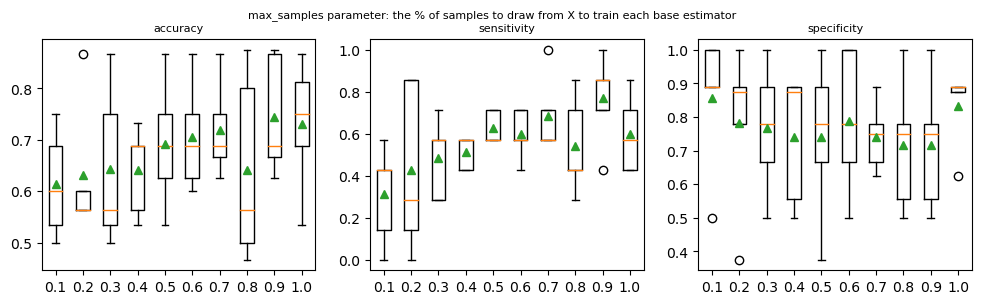

In [11]:
def plotFramework(resultsDict : dict,
                  scoringMetricsDict : dict, 
                  title : str) -> tuple[plt.figure, list[plt.axes]] :
    
    scoringMetricNames = list(scoringMetricsDict.keys())
    numMetrics = len(scoringMetricNames)
    fs = 8  # fontsize
    w = 12
    h = 3
    fig, axs = plt.subplots(nrows=1, ncols=numMetrics, figsize=(w, h), ) #sharey=True
    for i in range(0, numMetrics):
        metricName = scoringMetricNames[i]
        panel = axs[i]
        labels = resultsDict[metricName].keys()
        values = resultsDict[metricName].values()
        panel.boxplot(values, labels=labels, showmeans=True)
        # panel.set_title('max_samples' + " " + metricName, fontsize=fs)
        panel.set_title( metricName, fontsize=fs)
    
    fig.suptitle(title, fontsize=fs)
    return (fig, axs)

title='max_samples parameter: the % of samples to draw from X to train each base estimator'
fig, axs = plotFramework(maxSampleResultsDict, scoringMetricsDict, title)

imgFilePath = imgOut + "/max_samples.png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

**max_features** : defaults to the square root of the number of input features

max_features=2 accuracy	mean : 0.678 std : 0.164)
max_features=2 sensitivity	mean : 0.686 std : 0.167)
max_features=2 specificity	mean : 0.669 std : 0.241)

max_features=3 accuracy	mean : 0.757 std : 0.075)
max_features=3 sensitivity	mean : 0.657 std : 0.070)
max_features=3 specificity	mean : 0.836 std : 0.127)

max_features=4 accuracy	mean : 0.718 std : 0.125)
max_features=4 sensitivity	mean : 0.686 std : 0.107)
max_features=4 specificity	mean : 0.742 std : 0.176)

max_features=5 accuracy	mean : 0.743 std : 0.093)
max_features=5 sensitivity	mean : 0.657 std : 0.114)
max_features=5 specificity	mean : 0.808 std : 0.170)

max_features=6 accuracy	mean : 0.768 std : 0.100)
max_features=6 sensitivity	mean : 0.714 std : 0.128)
max_features=6 specificity	mean : 0.811 std : 0.102)

max_features=7 accuracy	mean : 0.706 std : 0.096)
max_features=7 sensitivity	mean : 0.600 std : 0.190)
max_features=7 specificity	mean : 0.789 std : 0.118)

saved image to /private/groups/kimlab/aedavids/elife/rando

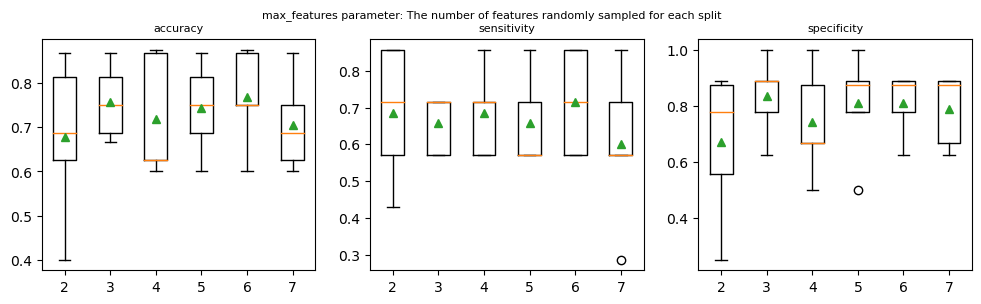

In [12]:
%%time
def createMaxFeaturesModels(XNP : np.array, bound : int) -> dict:
    nFeatures = XNP.shape[1]
    medianNFeatures = int( nFeatures**0.5 )
    start = medianNFeatures - bound
    if start < 1:
        start = 1
    end = medianNFeatures + bound
    
    modelDict = dict()
    for i in np.arange(start, end, 1):
        key = str(i)
        modelDict[key] = RandomForestClassifier(max_features=i)
    
    return modelDict

maxFeaturesModelDict = createMaxFeaturesModels(XNP, bound=3)

maxFeaturesResultsDict = tunningFramework(parameterName='max_features', 
                               modelDict=maxFeaturesModelDict,
                              XNP=XNP, yNP=yNP, scoringMetricsDict=scoringMetricsDict)

title='max_features parameter: The number of features randomly sampled for each split'
fig, axs = plotFramework(maxFeaturesResultsDict, scoringMetricsDict, title)

imgFilePath = imgOut + "/max_features.png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

**n_estimators** : The number of trees. Default 100

Increase number of trees till model performance stablizes.

Intuition might suggest
that more trees will lead to overfitting, although this is not the case. Both bagging and random
forest algorithms appear to be somewhat immune to overfitting the training dataset given the
stochastic nature of the learning algorithm.

n_estimators=50 accuracy	mean : 0.718 std : 0.112)
n_estimators=50 sensitivity	mean : 0.686 std : 0.107)
n_estimators=50 specificity	mean : 0.739 std : 0.191)

n_estimators=100 accuracy	mean : 0.666 std : 0.151)
n_estimators=100 sensitivity	mean : 0.600 std : 0.167)
n_estimators=100 specificity	mean : 0.714 std : 0.202)

n_estimators=500 accuracy	mean : 0.743 std : 0.093)
n_estimators=500 sensitivity	mean : 0.686 std : 0.107)
n_estimators=500 specificity	mean : 0.786 std : 0.165)

n_estimators=1000 accuracy	mean : 0.730 std : 0.115)
n_estimators=1000 sensitivity	mean : 0.629 std : 0.114)
n_estimators=1000 specificity	mean : 0.808 std : 0.170)

n_estimators=1500 accuracy	mean : 0.718 std : 0.122)
n_estimators=1500 sensitivity	mean : 0.629 std : 0.114)
n_estimators=1500 specificity	mean : 0.786 std : 0.179)

n_estimators=2000 accuracy	mean : 0.743 std : 0.093)
n_estimators=2000 sensitivity	mean : 0.686 std : 0.107)
n_estimators=2000 specificity	mean : 0.786 std : 0.179)

saved image to /

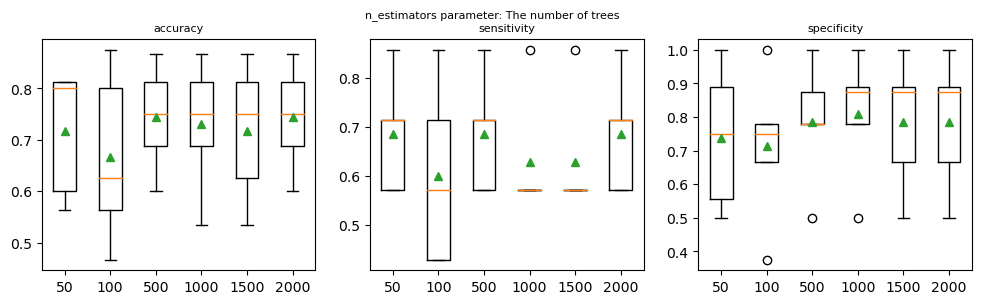

In [13]:
%%time
def createNumEstimatorsModels() -> dict:
    modelDict = dict()
    for i in [50, 100, 500, 1000, 1500, 2000]:
        key = str(i)
        modelDict[key] = RandomForestClassifier(n_estimators=i)
    
    return modelDict

numEstimatorModelDict = createNumEstimatorsModels()
numEstimatorResultsDict = tunningFramework(parameterName='n_estimators', 
                                         modelDict=numEstimatorModelDict,
                                          XNP=XNP, yNP=yNP, scoringMetricsDict=scoringMetricsDict)

title='n_estimators parameter: The number of trees'
fig, axs = plotFramework(numEstimatorResultsDict, scoringMetricsDict, title)

imgFilePath = imgOut + "/numTrees.png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

**max_depth** : tree depth

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

max_depth=1 accuracy	mean : 0.550 std : 0.097)
max_depth=1 sensitivity	mean : 0.229 std : 0.146)
max_depth=1 specificity	mean : 0.808 std : 0.154)

max_depth=2 accuracy	mean : 0.642 std : 0.095)
max_depth=2 sensitivity	mean : 0.571 std : 0.256)
max_depth=2 specificity	mean : 0.689 std : 0.225)

max_depth=3 accuracy	mean : 0.655 std : 0.112)
max_depth=3 sensitivity	mean : 0.600 std : 0.210)
max_depth=3 specificity	mean : 0.694 std : 0.105)

max_depth=4 accuracy	mean : 0.667 std : 0.111)
max_depth=4 sensitivity	mean : 0.657 std : 0.171)
max_depth=4 specificity	mean : 0.669 std : 0.231)

max_depth=5 accuracy	mean : 0.666 std : 0.155)
max_depth=5 sensitivity	mean : 0.600 std : 0.140)
max_depth=5 specificity	mean : 0.714 std : 0.247)

max_depth=6 accuracy	mean : 0.703 std : 0.158)
max_depth=6 sensitivity	mean : 0.629 std : 0.114)
max_depth=6 specificity	mean : 0.758 std : 0.254)

max_depth=7 accuracy	mean : 0.718 std : 0.088)
max_depth=7 sensitivity	mean : 0.629 std : 0.146)
max_depth=7 spe

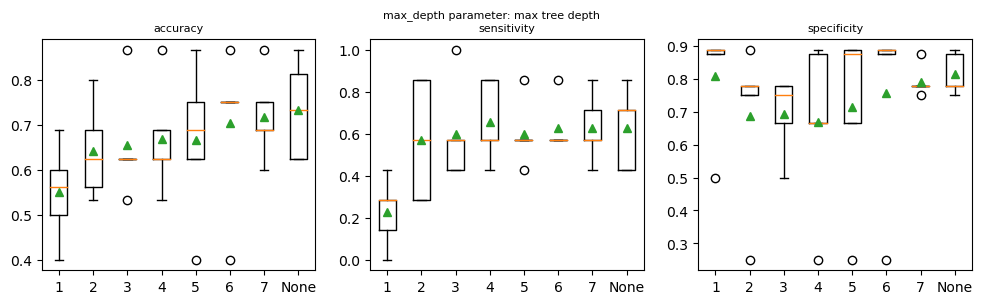

In [14]:
%%time
def createMaxDepthsModels() -> dict:
    modelDict = dict()
    depths = [i for i in range(1,8)] + [None]
    for i in depths:
        key = str(i)
        modelDict[key] = RandomForestClassifier(max_depth=i)
    
    return modelDict

maxDepthModelDict = createMaxDepthsModels()
maxDepthResultsDict = tunningFramework(parameterName='max_depth', 
                                         modelDict=maxDepthModelDict,
                                          XNP=XNP, yNP=yNP, scoringMetricsDict=scoringMetricsDict)

title='max_depth parameter: max tree depth'
fig, axs = plotFramework(maxDepthResultsDict, scoringMetricsDict, title)

imgFilePath = imgOut + "/max_depth.png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

# <span style="background-color:yellow;color:red">Review Hyperparmeter tunning</span>
02/01/2024 :output from extraCellularRNA/intraExtraRNA_POC/python/src/models/randomForestHyperparmeterSearch.py
- k-fold with 3 repeats and 5 splits to estimate the skill of model
- grid search 4572 points across hyper parameters (max_features,max_samples,n_estimators,max_depth).
- reported mean, and std for accuracy, specificity and sensitivity
- git commit id a06f7b1

In [15]:
modelOut = "/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/python/src/models"
outFile = "randomForestHyperparmeterSearch.a06f7b1-2024-02-01.csv"
fpath = modelOut + "/" + outFile

print(f'fpath:\n {fpath}')
rfhpDF = pd.read_csv(fpath)

print(f'rfhpDF.shape : {rfhpDF.shape}')
rfhpDF.head()

fpath:
 /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/python/src/models/randomForestHyperparmeterSearch.a06f7b1-2024-02-01.csv
rfhpDF.shape : (4752, 10)


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,max_features,max_samples,n_estimators,max_depth
0,0.743333,0.093489,0.800000,0.145686,0.691667,0.173561,8.0,0.9,100.0,5.0
1,0.769167,0.133739,0.800000,0.171429,0.741667,0.144765,6.0,0.8,50.0,6.0
2,0.716667,0.138669,0.771429,0.193781,0.666667,0.220129,8.0,1.0,100.0,5.0
3,0.781667,0.134283,0.771429,0.171429,0.783333,0.215989,8.0,0.5,100.0,7.0
4,0.754167,0.150555,0.771429,0.114286,0.736111,0.246582,5.0,0.9,100.0,NaN


In [16]:
threshold = 0.7
cols = ['sensitivity_mean', 'specificity_mean', 'max_features',	'max_samples', 'n_estimators',	'max_depth']

In [17]:
selectHighSensitivityRows = rfhpDF.loc[:, "sensitivity_mean"] >= threshold
highSensitivityDF = rfhpDF.loc[selectHighSensitivityRows, cols].sort_values(by="sensitivity_mean")
print(f'highSensitivityDF.shape : {highSensitivityDF.shape}')
highSensitivityDF.head()

highSensitivityDF.shape : (82, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
81,0.714286,0.786111,8.0,NaN,2000.0,7.0
57,0.714286,0.688889,5.0,0.9,50.0,7.0
58,0.714286,0.627778,5.0,0.6,100.0,NaN
59,0.714286,0.644444,4.0,NaN,50.0,5.0
61,0.714286,0.736111,4.0,NaN,100.0,5.0


In [18]:
selectHighSpecificityRows = rfhpDF.loc[:, "specificity_mean"] >= threshold
highSpecificityDF = rfhpDF.loc[selectHighSpecificityRows, cols].sort_values(by="specificity_mean")
print(f'highSpecificityDF.shape : {highSpecificityDF.shape}')
highSpecificityDF.head()

highSpecificityDF.shape : (3481, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
3208,0.485714,0.7,3.0,0.4,50.0,4.0
1699,0.600000,0.7,7.0,1.0,50.0,7.0
3186,0.485714,0.7,8.0,0.2,500.0,2.0
3081,0.485714,0.7,8.0,NaN,50.0,4.0
2247,0.571429,0.7,9.0,0.6,50.0,NaN


## hack for 2/8/24 1:1

In [19]:
AEDWIP_PYTHON_HACK = 999999999999

def exploreHyperparameterSearchResults() -> dict[dict]:
    '''
    returns a tree implemented as a dictionary of dictionaries
        outer keys:
            dict_keys(['sensitivity', 'specificity'])
        inner keys:
            dict_keys(['LUAD', 'LUSC', 'Lung', 'All'])

        inner values:
            data frame with columns 
                sensitivity_mean	specificity_mean	max_features	max_samples	n_estimators	max_depth
        
    '''
    
    rfHyperparemeterOut= "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"
    pattern="randomForestHyperparmeterSearch.csv"
    files = findFile(rfHyperparemeterOut, pattern)

    #threshold = 0.7
    cols = ['sensitivity_mean', 'specificity_mean', 'max_features',	'max_samples', 'n_estimators',	'max_depth']    

    retDict = dict()
    retDict['sensitivity'] = dict()
    retDict['specificity'] = dict()
    
    for filePath in files:
        # runName = randomForestHyperparmeterLUADSearch.sh.out
        runName = filePath.split("/")[7]
        
        # runName = randomForestHyperparmeterLUADSearch
        runName = runName.split(".")[0]
      
        tmp = runName.split("randomForestHyperparmeter")[1]
        featureSetName = tmp.split('Search')[0]  
    
        rfhpDF = pd.read_csv(filePath)
        #rfhpDF = rfhpDF.replace({np.nan: None})
        rfhpDF["max_depth"] = rfhpDF["max_depth"].replace( {np.nan : AEDWIP_PYTHON_HACK})
        rfhpDF["max_depth"] = rfhpDF["max_depth"].astype(int)
        # rfhpDF["max_depth"] = rfhpDF["max_depth"].replace( {AEDWIP, None} )

        rfhpDF["max_samples"] = rfhpDF["max_samples"].replace( {np.nan : AEDWIP_PYTHON_HACK})
        # rfhpDF["max_samples"] = rfhpDF["max_samples"].astype(int)

        rfhpDF["n_estimators"] = rfhpDF["n_estimators"].astype(int)
        rfhpDF['max_features']  = rfhpDF['max_features'].astype(int)

        
        print(f'\n{featureSetName} sorted by specificity')
        #selectHighSpecificityRows = rfhpDF.loc[:, "specificity_mean"] >= threshold
        # highSpecificityDF = rfhpDF.loc[selectHighSpecificityRows, cols].sort_values(by="specificity_mean", ascending=False)
        highSpecificityDF = rfhpDF.loc[:, cols].sort_values(by="specificity_mean", ascending=False)
        retDict['specificity'][featureSetName] = highSpecificityDF
        print(f'highSpecificityDF.shape : {highSpecificityDF.shape}')
        display( highSpecificityDF.head() )
        
        print(f'\n\n{featureSetName} sorted by sensitivity')
        #selectHighSensitivityRows = rfhpDF.loc[:, "sensitivity_mean"] >= threshold
        #highSensitivityDF = rfhpDF.loc[selectHighSensitivityRows, cols].sort_values(by="sensitivity_mean", ascending=False)
        highSensitivityDF = rfhpDF.loc[:, cols].sort_values(by="sensitivity_mean", ascending=False)
        retDict['sensitivity'][featureSetName] = highSensitivityDF
        print(f'highSensitivityDF.shape : {highSensitivityDF.shape}')
        display( highSensitivityDF.head() )

    return retDict
    
hyperSearchResultsDict = exploreHyperparameterSearchResults()


LUAD sorted by specificity
highSpecificityDF.shape : (3696, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
3645,0.057143,0.977778,1,0.7,50,1
3693,0.000000,0.977778,1,0.1,100,1
3695,0.000000,0.955556,1,1.0,1000,1
3663,0.057143,0.955556,1,0.2,1500,1
3650,0.057143,0.955556,1,0.8,500,1




LUAD sorted by sensitivity
highSensitivityDF.shape : (3696, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
0,0.371429,0.775000,1,0.9,100,7
1,0.371429,0.800000,2,0.7,100,7
2,0.371429,0.752778,3,0.4,50,999999999999
16,0.342857,0.797222,1,1.0,100,6
29,0.342857,0.727778,2,1.0,50,7



LUSC sorted by specificity
highSpecificityDF.shape : (3696, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
3408,0.0,1.0,1,0.5,100,1
3333,0.0,1.0,2,0.6,50,1
3526,0.0,1.0,6,0.1,500,1
3627,0.0,1.0,4,0.2,50,1
3314,0.0,1.0,3,0.1,500,1




LUSC sorted by sensitivity
highSensitivityDF.shape : (3696, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
0,0.514286,0.497222,7,0.1,50,1
1,0.457143,0.450000,3,0.1,50,999999999999
2,0.400000,0.550000,6,0.4,50,999999999999
3,0.371429,0.625000,3,0.1,50,6
4,0.371429,0.619444,6,0.1,50,2



Lung sorted by specificity
highSpecificityDF.shape : (3696, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
3694,0.057143,1.000000,1,0.1,2000,1
3693,0.085714,1.000000,1,0.3,1000,1
3657,0.142857,1.000000,1,0.8,500,1
3687,0.114286,1.000000,1,0.2,2000,1
3665,0.142857,0.977778,1,0.4,1500,1




Lung sorted by sensitivity
highSensitivityDF.shape : (3696, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
0,0.742857,0.716667,3,1.000000e+12,50,999999999999
2,0.742857,0.669444,6,8.000000e-01,100,6
3,0.742857,0.644444,1,7.000000e-01,50,5
4,0.742857,0.738889,3,3.000000e-01,50,999999999999
1,0.742857,0.719444,1,1.000000e+00,50,6



All sorted by specificity
highSpecificityDF.shape : (4752, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
4751,0.000000,1.0,1,0.8,500,1
4583,0.085714,1.0,3,0.1,2000,1
4692,0.000000,1.0,2,0.4,2000,1
4693,0.000000,1.0,1,0.3,2000,1
4694,0.000000,1.0,1,0.3,1500,1




All sorted by sensitivity
highSensitivityDF.shape : (4752, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
0,0.742857,0.713889,6,9.000000e-01,50,3
2,0.742857,0.719444,7,1.000000e+00,100,5
3,0.742857,0.783333,9,1.000000e+12,500,999999999999
1,0.742857,0.652778,7,1.000000e+00,50,6
4,0.742857,0.672222,6,8.000000e-01,100,5


## Create ROC and confusion matrix plots 
1. create models
2. train models
3. predict probablities
4. plot

**data model overview**  
a tree implemented as a dictionary of dictionaries
```
[specificity | sensitivity][LUAD | LUSC | Lung | All] [ model | predictedProbablities | predictions]
```

In [20]:
def createPlotDataDict(metrics : list[str], featureSets : list[str]) -> dict[dict]:
    plotDict = dict()

    for m in metrics:
        plotDict[m] = dict()
        for f in featureSets:
            plotDict[m][f] = dict()

    return plotDict

metrics = ['specificity', 'sensitivity']
featureSets = ['LUAD', 'LUSC', 'Lung', 'All']
plotDict = createPlotDataDict(metrics, featureSets)   

In [21]:
def createRandomForestModels( hyperSearchResultsDict : dict[dict],
                              plotDict : dict[dict], 
                              metrics : list[str], 
                              featureSets : list[str],
                            AEDWIP_PYTHON_HACK : int = 999999999999):
    '''
    create random forest models . stores model in  plotDict[m][f]['model']
    parameters dictionary in  plotDict[m][f]['parameters']
    '''
    parameters = ['max_features', 'max_samples', 'n_estimators', 'max_depth']
    for m in metrics:
        for f in featureSets:
            rfhpDF = hyperSearchResultsDict[m][f]
            # kwags is a dictionary. Keys parameters. values are parameter values
            kwags= rfhpDF.loc[:, parameters].head(n=1).to_dict(orient="records")[0]

            # RandomForestClassifier expects default value for max_depth = None
            # data frame columns can not be mixed type. None is not an in
            if kwags['max_depth'] == AEDWIP_PYTHON_HACK:
                kwags['max_depth'] = None 

            if kwags['max_samples'] == AEDWIP_PYTHON_HACK:
                kwags['max_samples'] = None             

            # if kwags['max_samples']== 0:
            #     kwags['max_samples' = 1
                
            plotDict[m][f]['parameters'] = kwags
            print(f'\nm: {m} f: {f}\n{kwags}')
            model = RandomForestClassifier(**kwags)
            #print(f'model.max_samples : {model.max_samples} model.n_estimators : {model.n_estimators}')
            plotDict[m][f]['model'] = model
           
    

createRandomForestModels(hyperSearchResultsDict, plotDict, metrics, featureSets)


m: specificity f: LUAD
{'max_features': 1, 'max_samples': 0.7000000000000001, 'n_estimators': 50, 'max_depth': 1}

m: specificity f: LUSC
{'max_features': 1, 'max_samples': 0.5, 'n_estimators': 100, 'max_depth': 1}

m: specificity f: Lung
{'max_features': 1, 'max_samples': 0.1, 'n_estimators': 2000, 'max_depth': 1}

m: specificity f: All
{'max_features': 1, 'max_samples': 0.8, 'n_estimators': 500, 'max_depth': 1}

m: sensitivity f: LUAD
{'max_features': 1, 'max_samples': 0.9, 'n_estimators': 100, 'max_depth': 7}

m: sensitivity f: LUSC
{'max_features': 7, 'max_samples': 0.1, 'n_estimators': 50, 'max_depth': 1}

m: sensitivity f: Lung
{'max_features': 3, 'max_samples': None, 'n_estimators': 50, 'max_depth': None}

m: sensitivity f: All
{'max_features': 6, 'max_samples': 0.9, 'n_estimators': 50, 'max_depth': 3}


In [22]:
def trainModels( plotDict : dict[dict], 
                    metrics : list[str], 
                    featureSets : list[str],
                    XNP : np.array, 
                    yNP : np.array, 
               ):
    '''
    TODO

    fits model, 
    stores predictions in  
        plotDict[m][f]['predictions']  
        plotDict[m][f]['predictedProbablities']  
    '''
    for m in metrics:
        for f in featureSets:
            print(f"\nm: {m} f: {f} parameters:\n{plotDict[m][f]['parameters']}")
            model = plotDict[m][f]['model'] 
            model.fit(XNP, yNP)
            plotDict[m][f]['predictions'] = model.predict(XNP)
            plotDict[m][f]['predictedProbablities']    = model.predict_proba(XNP)

trainModels(plotDict, metrics, featureSets, XNP, yNP)


m: specificity f: LUAD parameters:
{'max_features': 1, 'max_samples': 0.7000000000000001, 'n_estimators': 50, 'max_depth': 1}

m: specificity f: LUSC parameters:
{'max_features': 1, 'max_samples': 0.5, 'n_estimators': 100, 'max_depth': 1}

m: specificity f: Lung parameters:
{'max_features': 1, 'max_samples': 0.1, 'n_estimators': 2000, 'max_depth': 1}

m: specificity f: All parameters:
{'max_features': 1, 'max_samples': 0.8, 'n_estimators': 500, 'max_depth': 1}

m: sensitivity f: LUAD parameters:
{'max_features': 1, 'max_samples': 0.9, 'n_estimators': 100, 'max_depth': 7}

m: sensitivity f: LUSC parameters:
{'max_features': 7, 'max_samples': 0.1, 'n_estimators': 50, 'max_depth': 1}

m: sensitivity f: Lung parameters:
{'max_features': 3, 'max_samples': None, 'n_estimators': 50, 'max_depth': None}

m: sensitivity f: All parameters:
{'max_features': 6, 'max_samples': 0.9, 'n_estimators': 50, 'max_depth': 3}


In [23]:
def plotROC(
        panel : plt.axes, 
        y : np.array,
        yProbability : np.array,
        title : str,
    ) :
    '''
    plotsROC:

    TODO pass/inject function to ROCPlotFramework

    arguments:
        y : ground truth labels
        yProbability : predicted labels probablity
    '''
    # https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_roc
    rocPanel = skplt.metrics.plot_roc(y, yProbability,
                                    title=title,
                                    title_fontsize = "medium",
                                    text_fontsize = "small",
                                    ax = panel,
                                    plot_micro=False,
                                    plot_macro=False,
                                    )
    # imgRocFilePath = imgOut + "/trainingROC.png"
    # print(imgFilePath)
    # fig =rocPanel.get_figure()
    # fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    # print(f'saving:\n{imgRocFilePath}')



saving:
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out/img/Elife_Random_Forest_best10CuratedDegree1_ce467ff_intracellular_biomarkers_best_hyperparameter_results.png
saving:
/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples/Elife_Random_Forest_best10CuratedDegree1_ce467ff_intracellular_biomarkers_best_hyperparameter_results.png


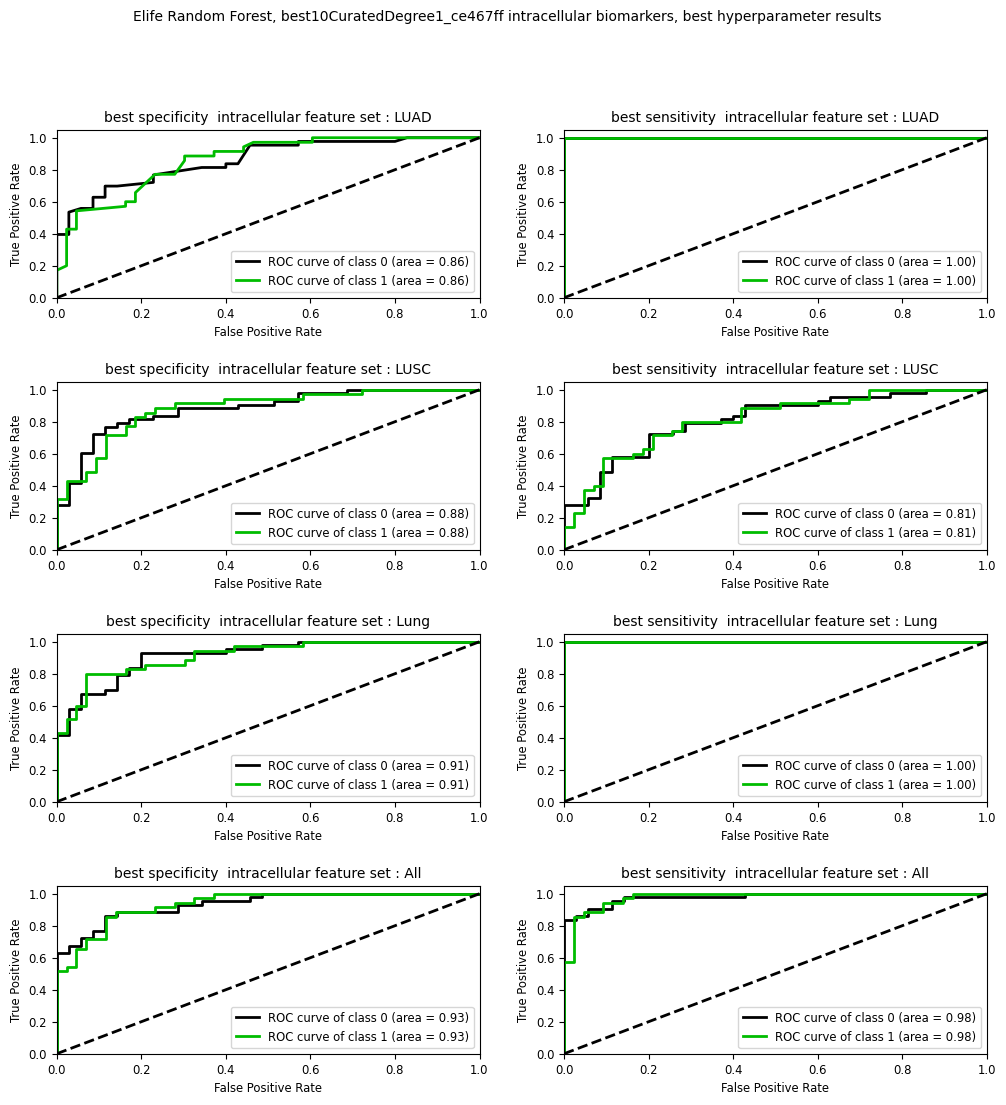

In [27]:
def ROCPlotFramework(
                    yNP : np.array,
                    plotDict : dict[dict], 
                    figTitle : str
                    )-> tuple[plt.figure, list[plt.axes]] :
    '''
    TODO
    
    Create a panal of ROC curves. The number of columns = number of metrics.
    The number of rows = the number of feature data sets

    arguments:
        yNP : ground truth labels
    '''
    
    metricsNames = list( plotDict.keys() )
    numMetrics = len(metricsNames)
    # print(f'numMetrics : {numMetrics}')

    firstMetricKey = list(plotDict.keys())[0]
    featureDataSetNames = list( plotDict[firstMetricKey].keys() )
    nRows = len(featureDataSetNames)
    # print(f'nRows : {nRows}')

    fs = 6 # 8  # fontsize
    w = 12
    h =  12 #10 #9 # 6 # 3
    fig, axs = plt.subplots(nrows=nRows, ncols=numMetrics, figsize=(w, h), ) #sharey=True
    #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.subplots_adjust(hspace=0.5)
    
    for i in range(0, nRows):
        featureDataSetName = featureDataSetNames[i]
        # print(f'i: {i} featureDataSetName : {featureDataSetName}')

        for j in range(0, numMetrics):
            metricName = metricsNames[j]
            # print(f'i : {i} j:{j} metricName : {metricName}')

            title = f'best {metricName}  intracellular feature set : {featureDataSetName}'
            panel = axs[i, j]
            yProbability = plotDict[metricName][featureDataSetName]['predictedProbablities'] 
            plotROC( panel, 
                    yNP, 
                    yProbability,
                    title,
            )
    
    fig.suptitle(figTitle, fontsize="medium")
    return (fig, axs)


title = 'Elife Random Forest, best10CuratedDegree1_ce467ff intracellular biomarkers, best hyperparameter results'
fig, axs = ROCPlotFramework(yNP, plotDict, title)

# save img close to ipynb file
file = "Elife_Random_Forest_best10CuratedDegree1_ce467ff_intracellular_biomarkers_best_hyperparameter_results.png"
imgFilePath = f'{imgOut}/{file}'
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saving:\n{imgFilePath}')

# save a copy along with rest of hyperparmeter results
rfHyperparemeterOut= "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"
tmpOutDir = f'{rfHyperparemeterOut}/{notebookName}'
os.makedirs(tmpOutDir, exist_ok=True)
imgFilePath = f'{tmpOutDir}/{file}'
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saving:\n{imgFilePath}')
